In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp
import pandas as pd
from shutil import copy

# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# My functions
import my_functions as mf

# tf explain
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [2]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [3]:
covid_metadata = pd.read_csv('datasets\ct_scan_3\meta_data_covid.csv')
non_covid_metadata = pd.read_csv('datasets\ct_scan_3\meta_data_normal.csv')

In [4]:
def copy_all_images_from_one_patient(patient_id, src_folder, dst_folder, metadata):
   try:
      patient_dataset = metadata.loc[metadata['Patient ID'] == patient_id]
      files = patient_dataset['File name']
      for file in files:
         src = src_folder + '\\' + file
         copy(src, dst_folder)
   except Exception as e:
      print('Copy error: {}'.format(e))

In [5]:
def random_split_patients(unique_patients_ids, validation_split):
   number_of_patients = len(unique_patients_ids)
   number_of_train_patients = int(number_of_patients * (1 - validation_split))
   
   np.random.shuffle(unique_patients_ids)
   train_patients_ids = unique_patients_ids[:number_of_train_patients]
   val_patients_ids = unique_patients_ids[number_of_train_patients:]
   
   return train_patients_ids, val_patients_ids

In [6]:
train_covid_patients_ids, val_covid_patients_ids = random_split_patients(covid_metadata['Patient ID'].unique(), 0.2)

In [7]:
for patient in train_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder = 'datasets\\ct_scan_3\\train\\COVID-positive', 
      metadata = covid_metadata)

Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%5.png'


In [8]:
for patient in val_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder = 'datasets\\ct_scan_3\\val\\COVID-positive', 
      metadata = covid_metadata)

Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%1.png'
Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%3.png'


In [9]:
train_non_covid_patients_ids, val_non_covid_patients_ids = random_split_patients(non_covid_metadata['Patient ID'].unique(), 0.2)

In [10]:
for patient in train_non_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder = 'datasets\\ct_scan_3\\train\\COVID-negative', 
      metadata = non_covid_metadata)

In [11]:
for patient in val_non_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder = 'datasets\\ct_scan_3\\val\\COVID-negative', 
      metadata = non_covid_metadata)

In [12]:
# 5575 + 5605 + 1318 + 1985 == 6893 + 7590

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='lanczos3', 
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 11217 files belonging to 2 classes.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='lanczos3', 
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 3266 files belonging to 2 classes.


In [17]:
3266  / 11217  

0.2911651956851208

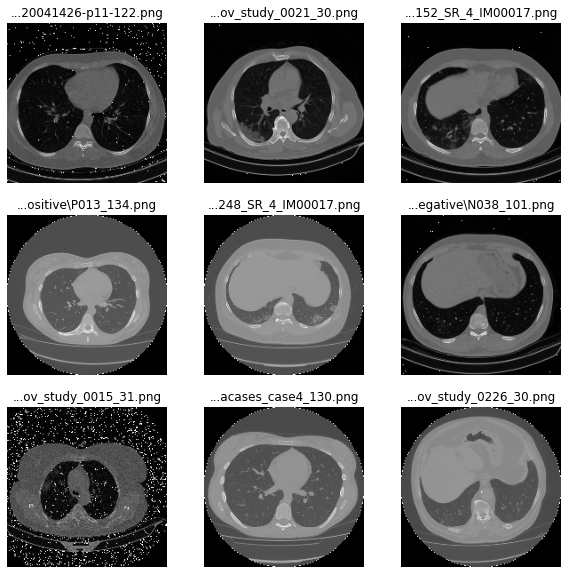

In [18]:
mf.check_dataset(train_ds)

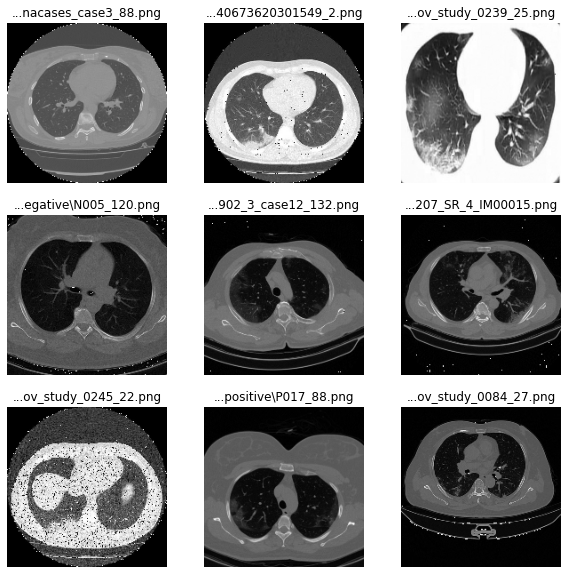

In [19]:
mf.check_dataset(val_ds)

In [20]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)
# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(last_layer_base_model.output)

# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(x)

# x = keras.layers.MaxPool2D()()

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

IMAGE_PATH = "datasets\\ct_scan_3\\val\\COVID-positive\\6_Rahimzadeh_157covid_patient141_SR_4_IM00015.png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

Epoch 1/100
351/351 [==============================] - 71s 170ms/step - loss: 0.5841 - accuracy: 0.7205 - val_loss: 0.3649 - val_accuracy: 0.8503
Epoch 2/100
351/351 [==============================] - 54s 154ms/step - loss: 0.4874 - accuracy: 0.7871 - val_loss: 0.3648 - val_accuracy: 0.8656
Epoch 3/100
351/351 [==============================] - 55s 157ms/step - loss: 0.4426 - accuracy: 0.8133 - val_loss: 0.3356 - val_accuracy: 0.8686
Epoch 4/100
351/351 [==============================] - 55s 158ms/step - loss: 0.4339 - accuracy: 0.8197 - val_loss: 0.3303 - val_accuracy: 0.8702
Epoch 5/100
351/351 [==============================] - 55s 158ms/step - loss: 0.4231 - accuracy: 0.8271 - val_loss: 0.3730 - val_accuracy: 0.8604
Epoch 6/100
351/351 [==============================] - 56s 160ms/step - loss: 0.4091 - accuracy: 0.8329 - val_loss: 0.3589 - val_accuracy: 0.8668
Epoch 7/100
351/351 [==============================] - 56s 158ms/step - loss: 0.4100 - accuracy: 0.8334 - val_loss: 0.3501 -

In [23]:
img_path = "datasets\\ct_scan_3\\val\\COVID-positive\\6_Rahimzadeh_157covid_patient141_SR_4_IM00015.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.7641488]], dtype=float32)

In [26]:
img_path = "datasets\\ct_scan_3\\val\\COVID-negative\\6_Rahimzadeh_normal2_patient298_SR_4_IM00017.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.40350437]], dtype=float32)

In [27]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

IMAGE_PATH = "datasets\\ct_scan_3\\val\\COVID-positive\\6_Rahimzadeh_157covid_patient141_SR_4_IM00015.png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
     callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

run_modeldir = mf.get_model_dir()
model.save(run_modeldir)

Epoch 1/100
351/351 [==============================] - 167s 429ms/step - loss: 0.4127 - accuracy: 0.8260 - val_loss: 0.2852 - val_accuracy: 0.9011
Epoch 2/100
351/351 [==============================] - 152s 434ms/step - loss: 0.3187 - accuracy: 0.8773 - val_loss: 0.2101 - val_accuracy: 0.9326
Epoch 3/100
351/351 [==============================] - 159s 453ms/step - loss: 0.2749 - accuracy: 0.9012 - val_loss: 0.1986 - val_accuracy: 0.9424
Epoch 4/100
351/351 [==============================] - 168s 480ms/step - loss: 0.2468 - accuracy: 0.9152 - val_loss: 0.2038 - val_accuracy: 0.9317
Epoch 5/100
351/351 [==============================] - 176s 501ms/step - loss: 0.2304 - accuracy: 0.9222 - val_loss: 0.1966 - val_accuracy: 0.9369
Epoch 6/100
351/351 [==============================] - 169s 482ms/step - loss: 0.2218 - accuracy: 0.9277 - val_loss: 0.1871 - val_accuracy: 0.9403
Epoch 7/100
351/351 [==============================] - 154s 438ms/step - loss: 0.2055 - accuracy: 0.9369 - val_loss: 0

In [28]:
model = keras.models.load_model("my_models\\model_0")

In [29]:
img_path = "datasets\\ct_scan_3\\val\\COVID-positive\\6_Rahimzadeh_157covid_patient141_SR_4_IM00015.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.9984079]], dtype=float32)

In [48]:
img_path = "datasets\\ct_scan_3\\full-COVID-positive\\6_Rahimzadeh_137covid_patient51_SR_4_IM00017.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.9993315]], dtype=float32)

In [51]:
IMAGE_PATH = "datasets\\ct_scan_3\\full-COVID-positive\\6_Rahimzadeh_137covid_patient51_SR_4_IM00017.png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)

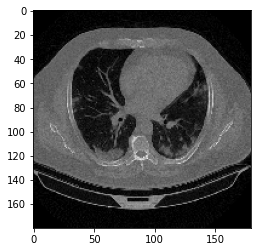

In [52]:
plt.imshow(mf.get_img_array(IMAGE_PATH, image_size)[0, :, :, :].astype(int))

In [53]:
from tf_explain.core.grad_cam import GradCAM

In [54]:
explainer = GradCAM()

In [55]:
grid = explainer.explain(data, model, class_index=0)

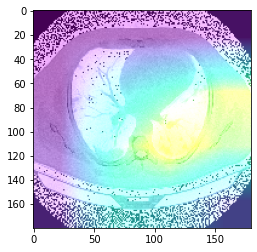

In [56]:
plt.imshow(grid)